The [new editor retention rate](https://meta.wikimedia.org/wiki/Research:Surviving_new_editor) suddenly spiked among the January 2018 cohort of new editors. Is this real and, if so, what caused it?

In [275]:
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [276]:
import wmfdata as wmf

In [277]:
# Customize Matplotlib styles
%matplotlib inline
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (16, 10)
pct_ax = mpl.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x))

# Data imports and transformation

## Monthly aggregates

In [319]:
glob_mo = pd.read_table("data/adl_global_monthly_retention.tsv")
glob_mo["reg_mo"] = pd.to_datetime(glob_mo["reg_mo"])
glob_mo = glob_mo.set_index("reg_mo")
glob_mo.head()

,new_eds,ret
reg_mo,,
2001-01-01,6,0.500000
2001-02-01,5,0.600000
2001-03-01,13,0.538462
2001-04-01,11,0.272727
2001-05-01,13,0.615385


In [325]:
glob_mo.tail()

,new_eds,ret
reg_mo,,
2017-10-01,110347,0.074211
2017-11-01,110464,0.054036
2017-12-01,97736,0.052366
2018-01-01,113366,0.077360
2018-02-01,103494,0.066922


In [297]:
proj_mo = pd.read_table("data/adl_project_monthly_retention.tsv")
proj_mo["reg_mo"] = pd.to_datetime(proj_mo["reg_mo"])
proj_mo.head()

,wiki,reg_mo,new_eds,ret
0,abwiki,2004-01-01,1,0.0
1,abwiki,2004-08-01,1,0.0
2,abwiki,2004-11-01,2,0.0
3,abwiki,2004-12-01,2,0.5
4,abwiki,2005-01-01,1,0.0


## English Wikipedia new editors

### Revisions from MariaDB

In [361]:
mdb_en_revs = pd.read_table(
    "data/mdb_enwiki_new_editor_revisions.tsv",
    parse_dates=["reg_dt", "rev_dt"],
    dtype={
        "mob": np.bool,
        "ve": np.bool
    }
)

td_30 = dt.timedelta(days = 30)
td_60 = dt.timedelta(days = 60)

mdb_en_revs["since_reg"] = mdb_en_revs["rev_dt"] - mdb_en_revs["reg_dt"]
mdb_en_revs["first_mo"] = mdb_en_revs["since_reg"] < td_30
mdb_en_revs["second_mo"] = (mdb_en_revs["since_reg"] >= td_30) & (mdb_en_revs["since_reg"] < td_60)

mdb_en_revs.head()

,name,rev_id,reg_dt,rev_dt,mob,ve,since_reg,first_mo,second_mo
0,HappyPaige627,752388509,2016-12-01 00:00:15,2016-12-01 00:01:48,False,False,00:01:33,True,False
1,Toppu Kaeru,752389022,2016-12-01 00:01:09,2016-12-01 00:04:02,False,False,00:02:53,True,False
2,GAdams,752389051,2016-12-01 00:03:08,2016-12-01 00:04:09,True,False,00:01:01,True,False
3,Albitr,752389167,2016-12-01 00:00:34,2016-12-01 00:04:44,False,True,00:04:10,True,False
4,Ltclaws,752390193,2016-12-01 00:02:26,2016-12-01 00:09:38,False,True,00:07:12,True,False


In [ ]:
mdb_en_new = mdb_en_revs.groupby("name").agg({
    "reg_dt": lambda x: dt.datetime.date(np.min(x)),
    "first_mo": np.sum,
    "second_mo": np.sum,
    "mob": np.sum,
    "ve": np.sum
})

mdb_en_new = mdb_en_new.rename(columns = {
    "reg_dt": "reg_day",
    "first_mo": "mo_1_revs",
    "second_mo": "mo_2_revs",
    "mob": "mob_revs",
    "ve": "ve_revs"
}).reset_index()

In [373]:
mdb_en_new.head()

,name,reg_day,mo_1_revs,mo_2_revs,mob_revs,ve_revs
0,!!Ethereal!!,2018-02-06,2.0,0.0,0.0,0.0
1,!!Hûm Såfår!!,2017-02-23,2.0,0.0,2.0,1.0
2,!.Jimiey.!,2016-12-17,2.0,0.0,0.0,2.0
3,!0Clarke,2018-01-06,3.0,0.0,0.0,0.0
4,!0MinutesADay,2017-11-17,1.0,0.0,0.0,0.0


In [378]:
mdb_en_d = mdb_en_new.groupby("reg_day").agg({
    "mo_1_revs": {"mo_1_eds": np.count_nonzero, "mo_1_revs": np.sum},
    "mo_2_revs": {"mo_2_eds": np.count_nonzero, "mo_2_revs": np.sum},
    "mob_revs": {"mob_revs": np.sum},
    "ve_revs": {"ve_revs": np.sum}
})

# Flatten the multi-level column labels
mdb_en_d.columns = [col[1] for col in mdb_en_d.columns]

# Calculate retention
mdb_en_d["ret"] = mdb_en_d["mo_2_eds"] / mdb_en_d["mo_1_eds"]

mdb_en_d.head()

,mo_2_revs,mo_2_eds,ve_revs,mo_1_revs,mo_1_eds,mob_revs,ret
reg_day,,,,,,,
2016-12-01,1135.0,85.0,3104.0,8121.0,1470.0,1623.0,0.057823
2016-12-02,1534.0,79.0,1334.0,7260.0,1459.0,2358.0,0.054147
2016-12-03,973.0,74.0,1221.0,7051.0,1211.0,2226.0,0.061107
2016-12-04,1178.0,77.0,1253.0,5830.0,1293.0,2462.0,0.059551
2016-12-05,1079.0,84.0,1398.0,6732.0,1509.0,3570.0,0.055666


### Revisions from the Analytics Data Lake

In [333]:
adl_en_new = pd.read_table("data/adl_enwiki_new_editors.tsv", parse_dates = ["reg_day"])
adl_en_new.head()

,name,reg_day,mo_1_revs,mo_2_revs,mo_1_reverts,mo_2_reverts
0,!!Ethereal!!,2018-02-06,2,0,0,0
1,!!Hûm Såfår!!,2017-02-23,4,0,1,0
2,!.Jimiey.!,2016-12-17,2,0,2,0
3,!0Clarke,2018-01-06,3,0,1,0
4,!0MinutesADay,2017-11-17,1,0,0,0


In [377]:
adl_en_d = adl_en_new.groupby("reg_day").agg({
    "mo_1_revs": {"mo_1_eds": np.count_nonzero, "mo_1_revs": np.sum},
    "mo_2_revs": {"mo_2_eds": np.count_nonzero, "mo_2_revs": np.sum},
    "mo_1_reverts": {"mo_1_reverts": np.sum},
    "mo_2_reverts": {"mo_2_reverts": np.sum}
})

# Flatten the multi-level column labels
adl_en_d.columns = [col[1] for col in adl_en_d.columns]

# Calculate retention
adl_en_d["ret"] = adl_en_d["mo_2_eds"] / adl_en_d["mo_1_eds"]

adl_en_d.head()

,mo_2_revs,mo_2_eds,mo_1_revs,mo_1_eds,mo_1_reverts,mo_2_reverts,ret
reg_day,,,,,,,
2016-12-01,967,73,9275,1692,2294,149,0.043144
2016-12-02,1618,71,8890,1657,1957,206,0.042849
2016-12-03,1079,69,8280,1370,1905,114,0.050365
2016-12-04,1158,60,6973,1453,1626,103,0.041294
2016-12-05,1279,73,8310,1711,1987,144,0.042665


### Daily aggregates

In [379]:
en_d = adl_en_d.join(mdb_en_d, lsuffix = "_adl", rsuffix="_mdb")

In [380]:
en_d.head()

,mo_2_revs_adl,mo_2_eds_adl,mo_1_revs_adl,mo_1_eds_adl,mo_1_reverts,mo_2_reverts,ret_adl,mo_2_revs_mdb,mo_2_eds_mdb,ve_revs,mo_1_revs_mdb,mo_1_eds_mdb,mob_revs,ret_mdb
reg_day,,,,,,,,,,,,,,
2016-12-01,967,73,9275,1692,2294,149,0.043144,1135.0,85.0,3104.0,8121.0,1470.0,1623.0,0.057823
2016-12-02,1618,71,8890,1657,1957,206,0.042849,1534.0,79.0,1334.0,7260.0,1459.0,2358.0,0.054147
2016-12-03,1079,69,8280,1370,1905,114,0.050365,973.0,74.0,1221.0,7051.0,1211.0,2226.0,0.061107
2016-12-04,1158,60,6973,1453,1626,103,0.041294,1178.0,77.0,1253.0,5830.0,1293.0,2462.0,0.059551
2016-12-05,1279,73,8310,1711,1987,144,0.042665,1079.0,84.0,1398.0,6732.0,1509.0,3570.0,0.055666


In [392]:
en_d_r = en_d.rolling(7).mean()

# Retention throughout history

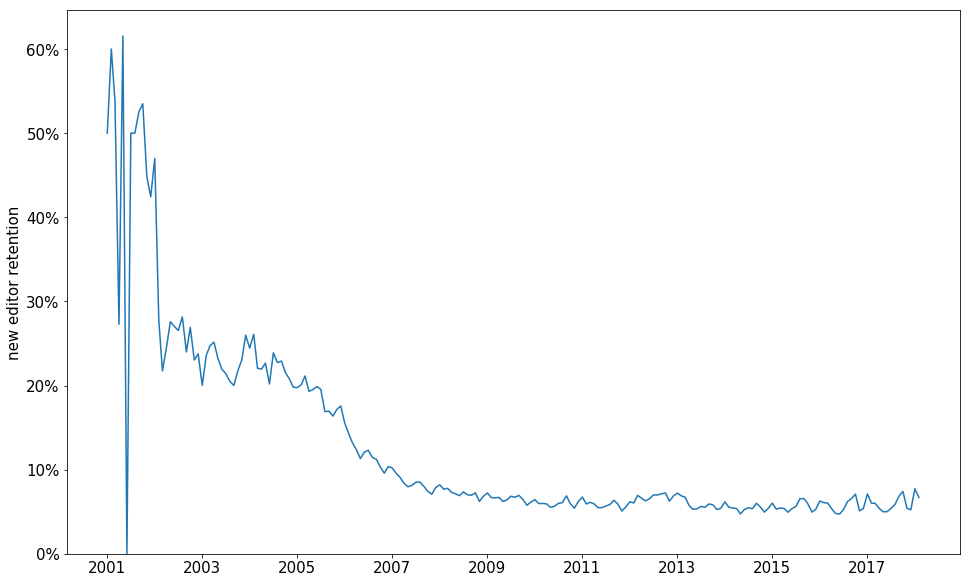

In [383]:
plt.plot(glob_mo["ret"])
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.ylim(ymin=0);

Without the pre-2005 insanity:

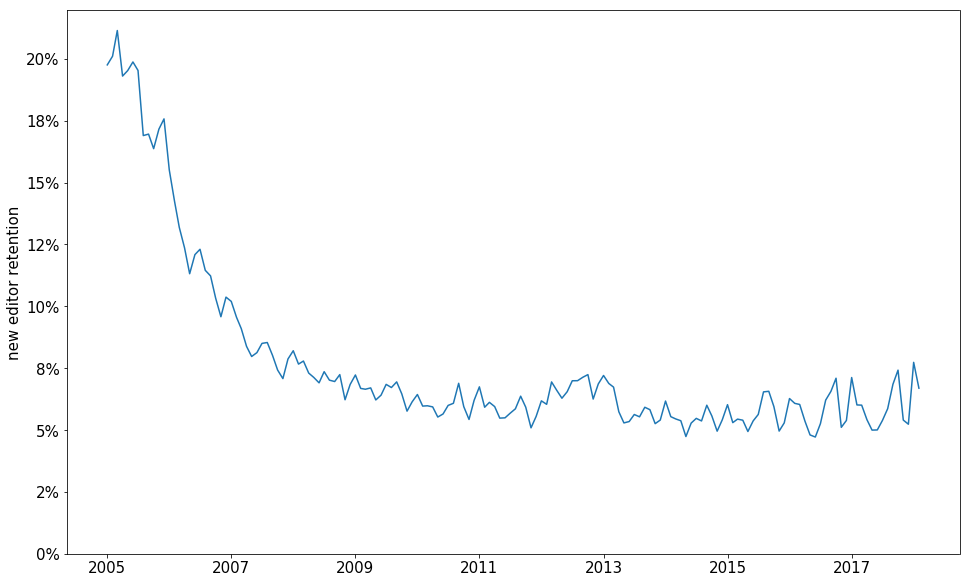

In [384]:
jan_2005 = dt.datetime(2005, 1, 1)
plt.plot(glob_mo["ret"][jan_2005:])
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.ylim(ymin=0);

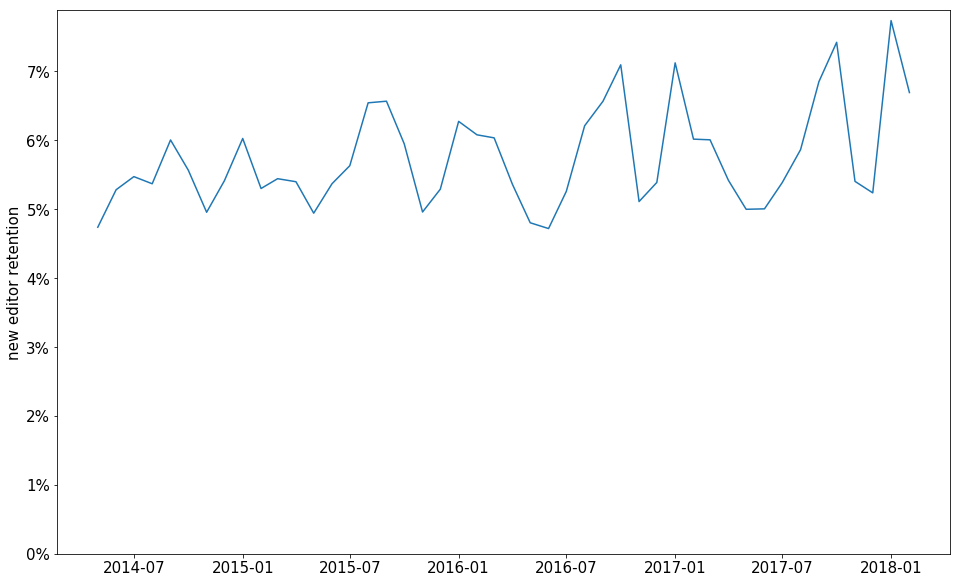

In [385]:
back_4_years = dt.datetime(2014, 5, 1)
plt.plot(glob_mo["ret"][back_4_years:])
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.ylim(ymin=0);

# The scene of the crime: English Wikipedia

In [386]:
def global_retention(df):
    return (df["new_eds"] * df["ret"]).sum() / df["new_eds"].sum()

en_mo = proj_mo.query("wiki == 'enwiki'").groupby("reg_mo").apply(global_retention)
non_en_mo = proj_mo.query("wiki != 'enwiki'").groupby("reg_mo").apply(global_retention)

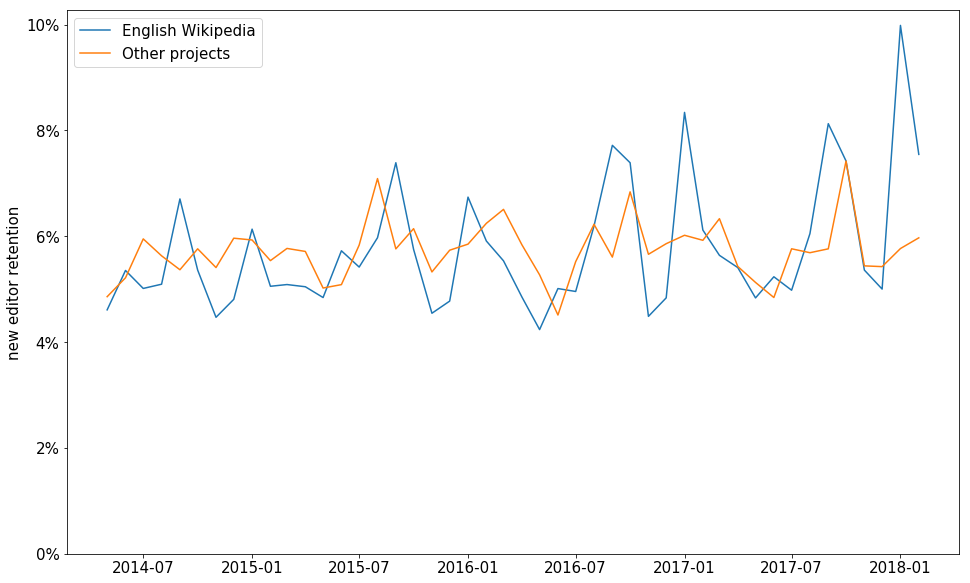

In [388]:
# Same, for the past 4 years
plt.plot(en_mo[back_4_years:], label="English Wikipedia")
plt.plot(non_en_mo[back_4_years:], label="Other projects")
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention")
plt.legend()
plt.ylim(ymin=0);

The Analytics Data Lake and MariaDB numbers won't match because the MariaDB numbers exclude deleted users, but let's see if the trends are the same.

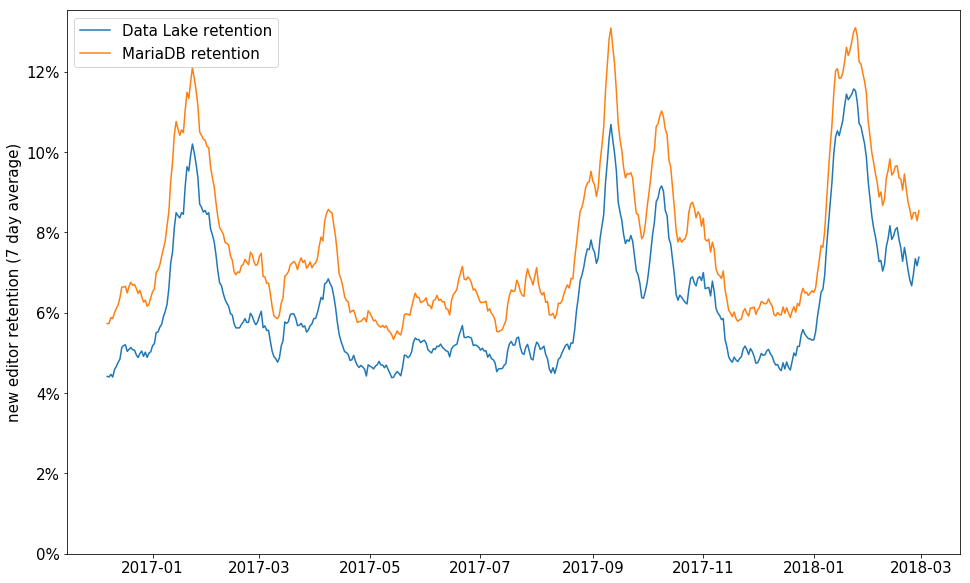

In [394]:
plt.plot(en_d_r["ret_adl"], label="Data Lake retention")
plt.plot(en_d_r["ret_mdb"], label="MariaDB retention")
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylabel("new editor retention (7 day average)")
plt.legend()
plt.ylim(ymin=0);

What's the relationship between the number of new editors from a day's cohort and their retention rates?

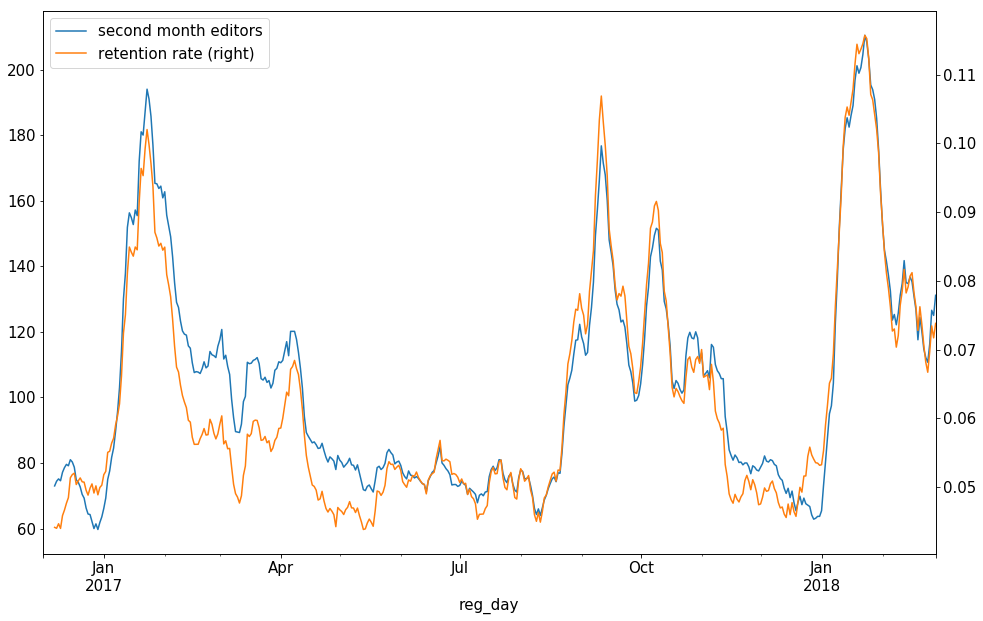

In [396]:
en_d_r.mo_2_eds_adl.plot(label="second month editors", legend=True)
en_d_r.ret_adl.plot(secondary_y=True, label="retention rate", legend=True);